# Exploratory Data Analysis and Feature Group

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import hopsworks
import joblib
from datetime import datetime, timedelta
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.synthesizers.regular import RegularSynthesizer
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
from utils import InversePipeline

sns.set_palette('husl')
%matplotlib inline

2023-12-29 00:11:19.988722: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-29 00:11:20.027205: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-29 00:11:20.028014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-29 00:11:20.569294: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/196773
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
heart_df = pd.read_csv('dataset/heart.csv')

In [4]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [5]:
heart_df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


In [6]:
heart_df.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

# Preprocessing

In [7]:
# Add timestamp to each row and subtract 1 day (to ensure not considering this data as new data on the monitoring job)
heart_df['timestamp'] = pd.to_datetime(datetime.now() - timedelta(days=1))

# Change all column names from CamelCase to snake_case
import re
pattern = re.compile(r'(?<!^)(?=[A-Z])')
heart_df.columns = map(lambda x: pattern.sub('_', x).lower(), heart_df.columns)

# target features
heart_df["heart_disease"] = (heart_df["heart_disease"] == "Yes").astype(np.float64)

# Store the dataset locally
heart_df.to_csv('dataset/heart_preprocessed.csv', index=False)

In [8]:
heart_df.columns

Index(['heart_disease', 'b_m_i', 'smoking', 'alcohol_drinking', 'stroke',
       'physical_health', 'mental_health', 'diff_walking', 'sex',
       'age_category', 'race', 'diabetic', 'physical_activity', 'gen_health',
       'sleep_time', 'asthma', 'kidney_disease', 'skin_cancer', 'timestamp'],
      dtype='object')

In [9]:
categorical = heart_df.select_dtypes(['object']).columns
categorical

Index(['smoking', 'alcohol_drinking', 'stroke', 'diff_walking', 'sex',
       'age_category', 'race', 'diabetic', 'physical_activity', 'gen_health',
       'asthma', 'kidney_disease', 'skin_cancer'],
      dtype='object')

In [10]:
# Print all the possible values for each categorical column
for col in categorical:
    categorical_values = heart_df[col].unique()
    print(f'Column {col} has {len(categorical_values)} unique values: {sorted(categorical_values)}')

Column smoking has 2 unique values: ['No', 'Yes']
Column alcohol_drinking has 2 unique values: ['No', 'Yes']
Column stroke has 2 unique values: ['No', 'Yes']
Column diff_walking has 2 unique values: ['No', 'Yes']
Column sex has 2 unique values: ['Female', 'Male']
Column age_category has 13 unique values: ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']
Column race has 6 unique values: ['American Indian/Alaskan Native', 'Asian', 'Black', 'Hispanic', 'Other', 'White']
Column diabetic has 4 unique values: ['No', 'No, borderline diabetes', 'Yes', 'Yes (during pregnancy)']
Column physical_activity has 2 unique values: ['No', 'Yes']
Column gen_health has 5 unique values: ['Excellent', 'Fair', 'Good', 'Poor', 'Very good']
Column asthma has 2 unique values: ['No', 'Yes']
Column kidney_disease has 2 unique values: ['No', 'Yes']
Column skin_cancer has 2 unique values: ['No', 'Yes']


In [11]:
# print all columns that are not categorical
numerical = heart_df.columns.difference(categorical)
numerical

Index(['b_m_i', 'heart_disease', 'mental_health', 'physical_health',
       'sleep_time', 'timestamp'],
      dtype='object')

In [12]:
# Create pipeline for numerical features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Create pipeline for categorical features
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop="first", sparse_output=False))
])

# Remove heartdisease (target) and timestamp (time) if it exists
droped_columns = ['timestamp', 'heart_disease']
categorical = categorical.difference(droped_columns)
numerical = numerical.difference(droped_columns)

# Create preprocessing pipeline
preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical),
    ('categorical', categorical_pipeline, categorical)
], remainder='drop')

In [13]:
preprocessing_pipeline.fit(heart_df)

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 Index(['b_m_i', 'mental_health', 'physical_health', 'sleep_time'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 Index(['age_category', 'alcohol_drinking', 'asthma', 'diabetic',
       'diff_walking', 'gen_health', 'kidney_disease', 'physical_activity',
       'race', 'sex', 'skin_cancer', 'smoking', 'stroke'],
      dtype='object'))])

In [14]:
y = heart_df['heart_disease']
X = preprocessing_pipeline.transform(heart_df)

In [15]:
new_categorical = preprocessing_pipeline.transformers_[1][1]['encoder'].get_feature_names_out(categorical.tolist())

transformed_df = pd.DataFrame(X, columns=numerical.tolist() + new_categorical.tolist())
transformed_df['heart_disease'] = y

In [16]:
transformed_df.describe()

,b_m_i,mental_health,physical_health,sleep_time,age_category_25-29,age_category_30-34,age_category_35-39,age_category_40-44,age_category_45-49,age_category_50-54,...,race_Asian,race_Black,race_Hispanic,race_Other,race_White,sex_Male,skin_cancer_Yes,smoking_Yes,stroke_Yes,heart_disease
count,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,...,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000
mean,0.196854,0.129946,0.112390,0.265090,0.053018,0.058641,0.064260,0.065686,0.068141,0.079370,...,0.025229,0.071730,0.085824,0.034172,0.766779,0.475273,0.093244,0.412477,0.037740,0.085595
std,0.076737,0.265175,0.265028,0.062435,0.224070,0.234951,0.245216,0.247733,0.251987,0.270315,...,0.156819,0.258041,0.280104,0.181671,0.422883,0.499389,0.290775,0.492281,0.190567,0.279766
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.144996,0.000000,0.000000,0.217391,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.184957,0.000000,0.000000,0.260870,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.234215,0.100000,0.066667,0.304348,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
# Stores the preprocessing pipeline in the model directory
model_dir = 'heart_model'

os.makedirs(model_dir, exist_ok=True)
joblib.dump(preprocessing_pipeline, f'{model_dir}/preprocessing_pipeline.pkl')

['heart_model/preprocessing_pipeline.pkl']

In [18]:
inverse_pipeline = InversePipeline(preprocessing_pipeline, heart_df.columns)

In [19]:
inverse_pipeline.transform(X, y).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   heart_disease      319795 non-null  category
 1   b_m_i              319795 non-null  float64 
 2   smoking            319795 non-null  category
 3   alcohol_drinking   319795 non-null  category
 4   stroke             319795 non-null  category
 5   physical_health    319795 non-null  float64 
 6   mental_health      319795 non-null  float64 
 7   diff_walking       319795 non-null  category
 8   sex                319795 non-null  category
 9   age_category       319795 non-null  category
 10  race               319795 non-null  category
 11  diabetic           319795 non-null  category
 12  physical_activity  319795 non-null  category
 13  gen_health         319795 non-null  category
 14  sleep_time         319795 non-null  float64 
 15  asthma             319795 non-null

# Exploration

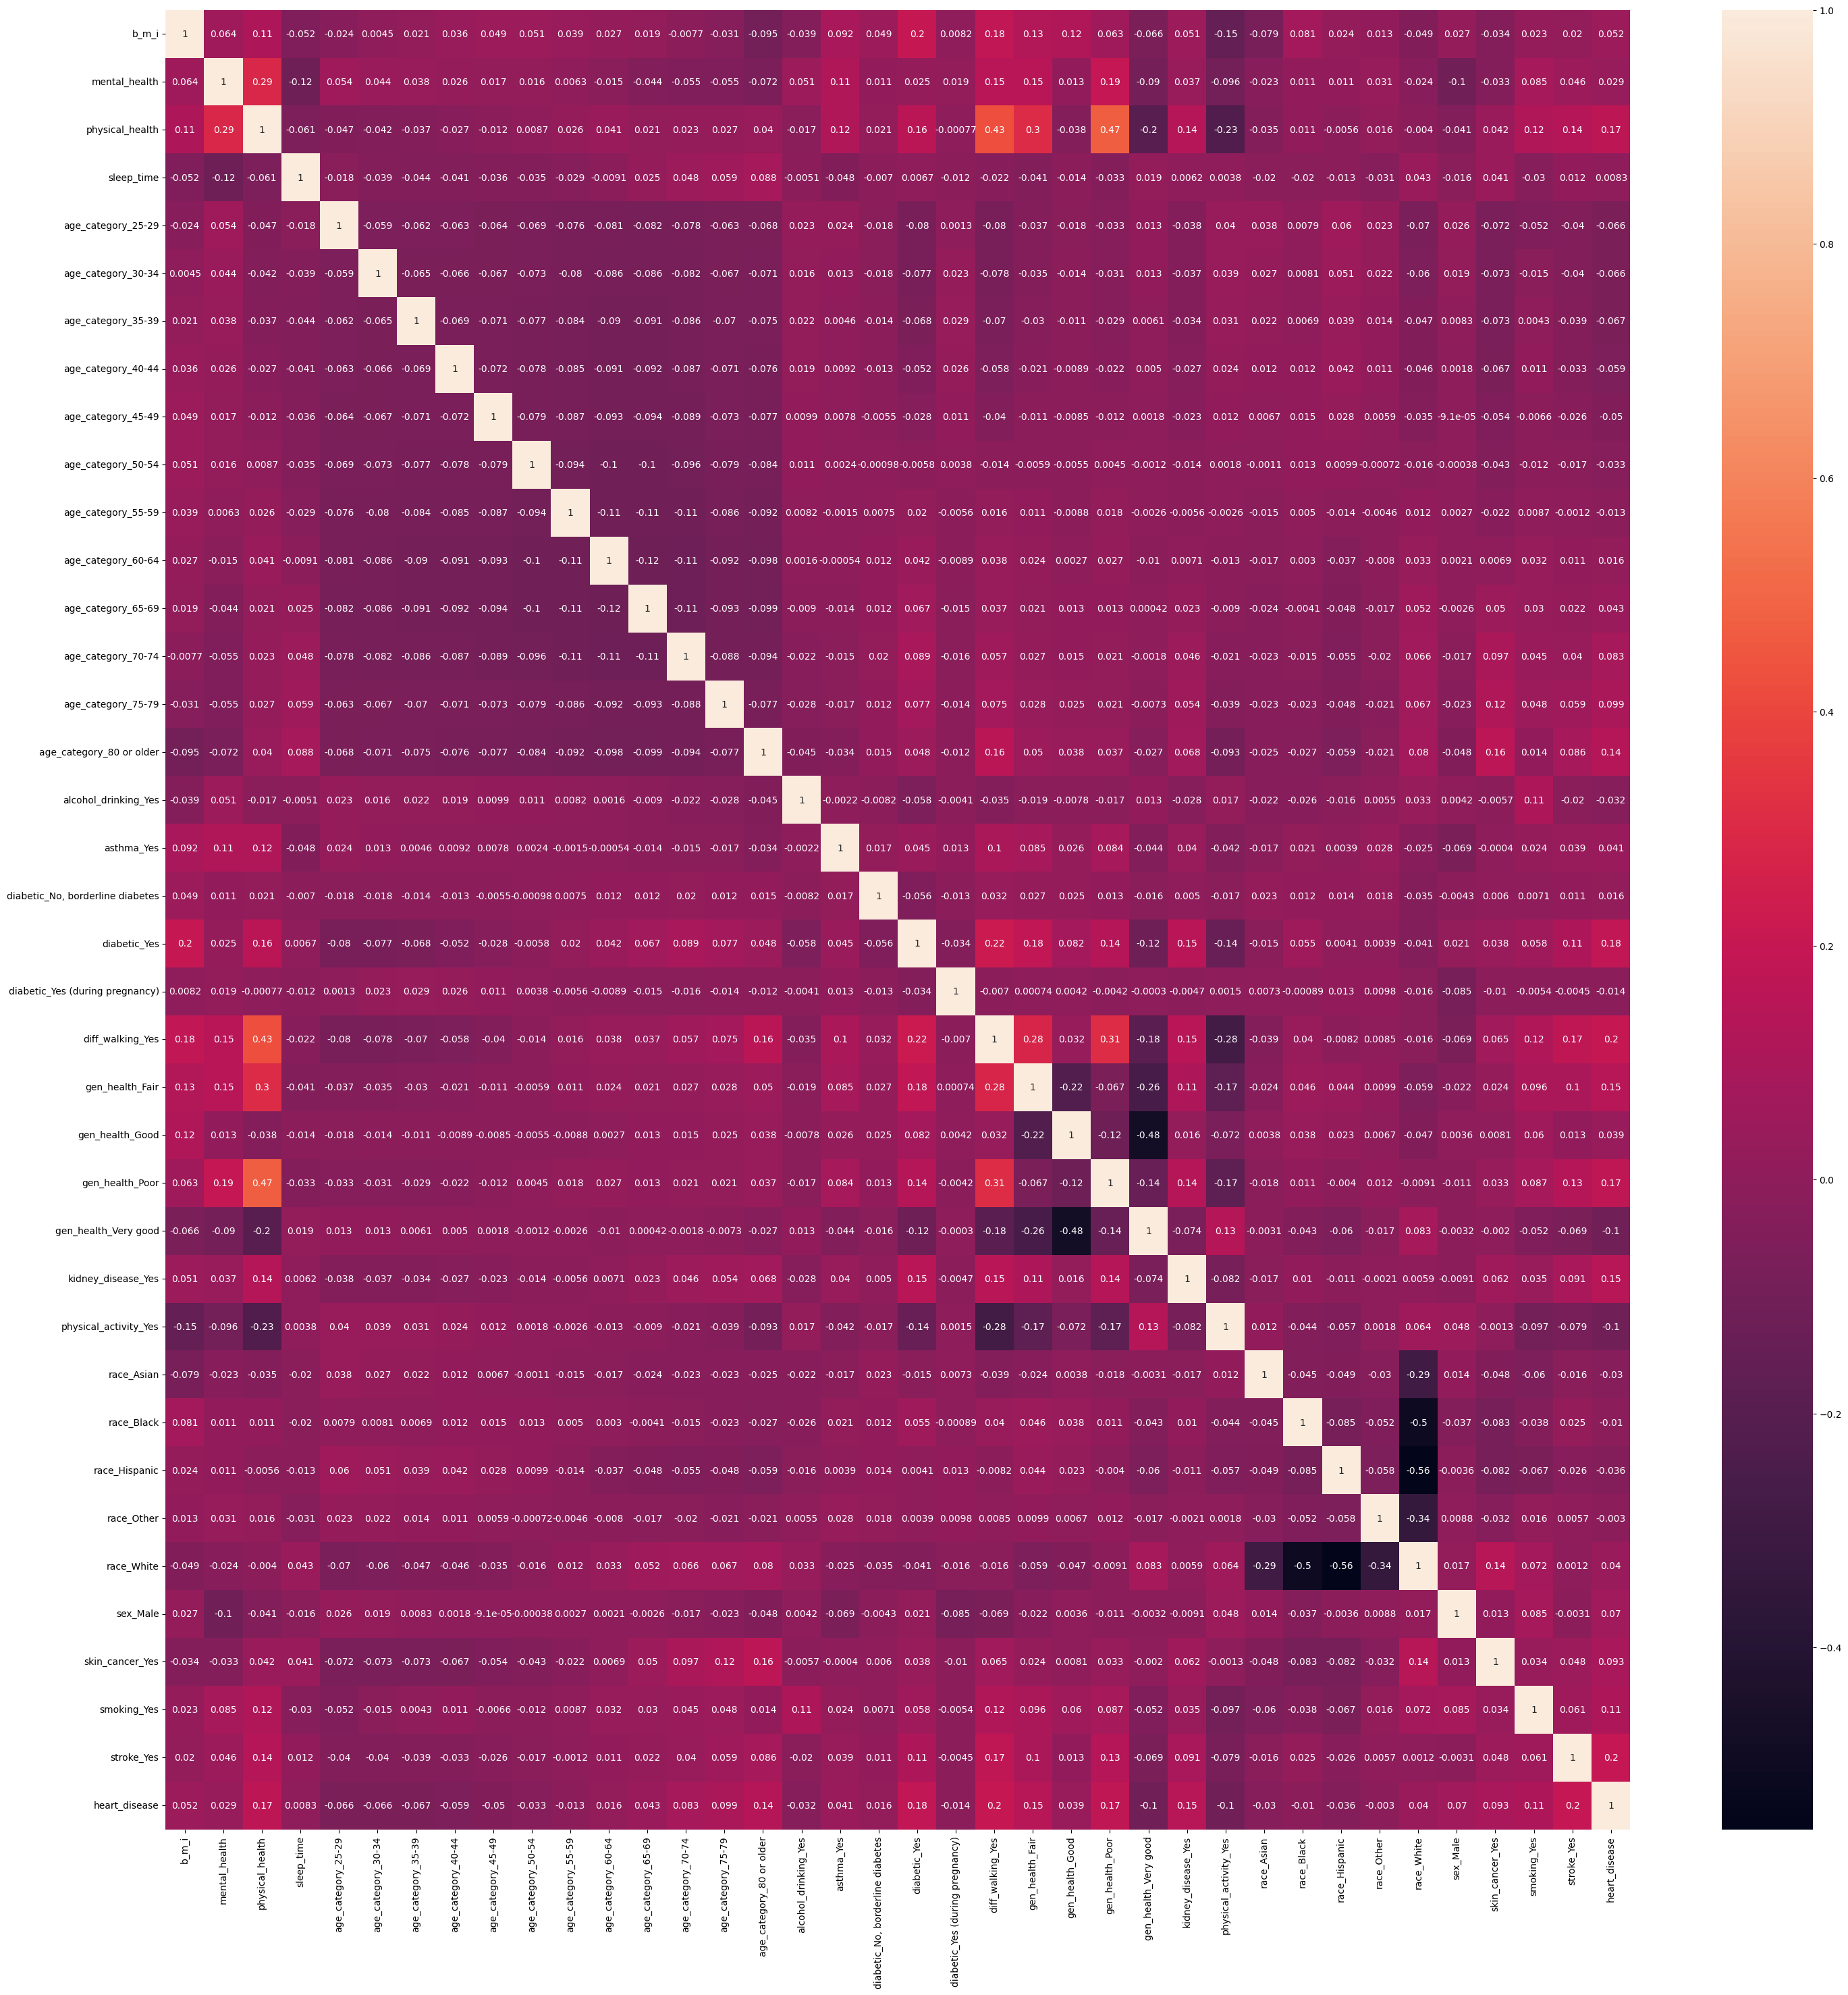

In [20]:
corr = transformed_df.corr()
plt.figure(figsize=(35, 35))
sns.heatmap(corr, annot=True)
plt.show()

In [21]:
corr = corr.abs().unstack()
corr = corr.sort_values(ascending=False)
corr = corr[corr >= 0.1]
print(corr["heart_disease"])

heart_disease               1.000000
diff_walking_Yes            0.201258
stroke_Yes                  0.196835
diabetic_Yes                0.183072
gen_health_Poor             0.174662
physical_health             0.170721
gen_health_Fair             0.147954
kidney_disease_Yes          0.145197
age_category_80 or older    0.143041
smoking_Yes                 0.107764
gen_health_Very good        0.101886
physical_activity_Yes       0.100030
dtype: float64


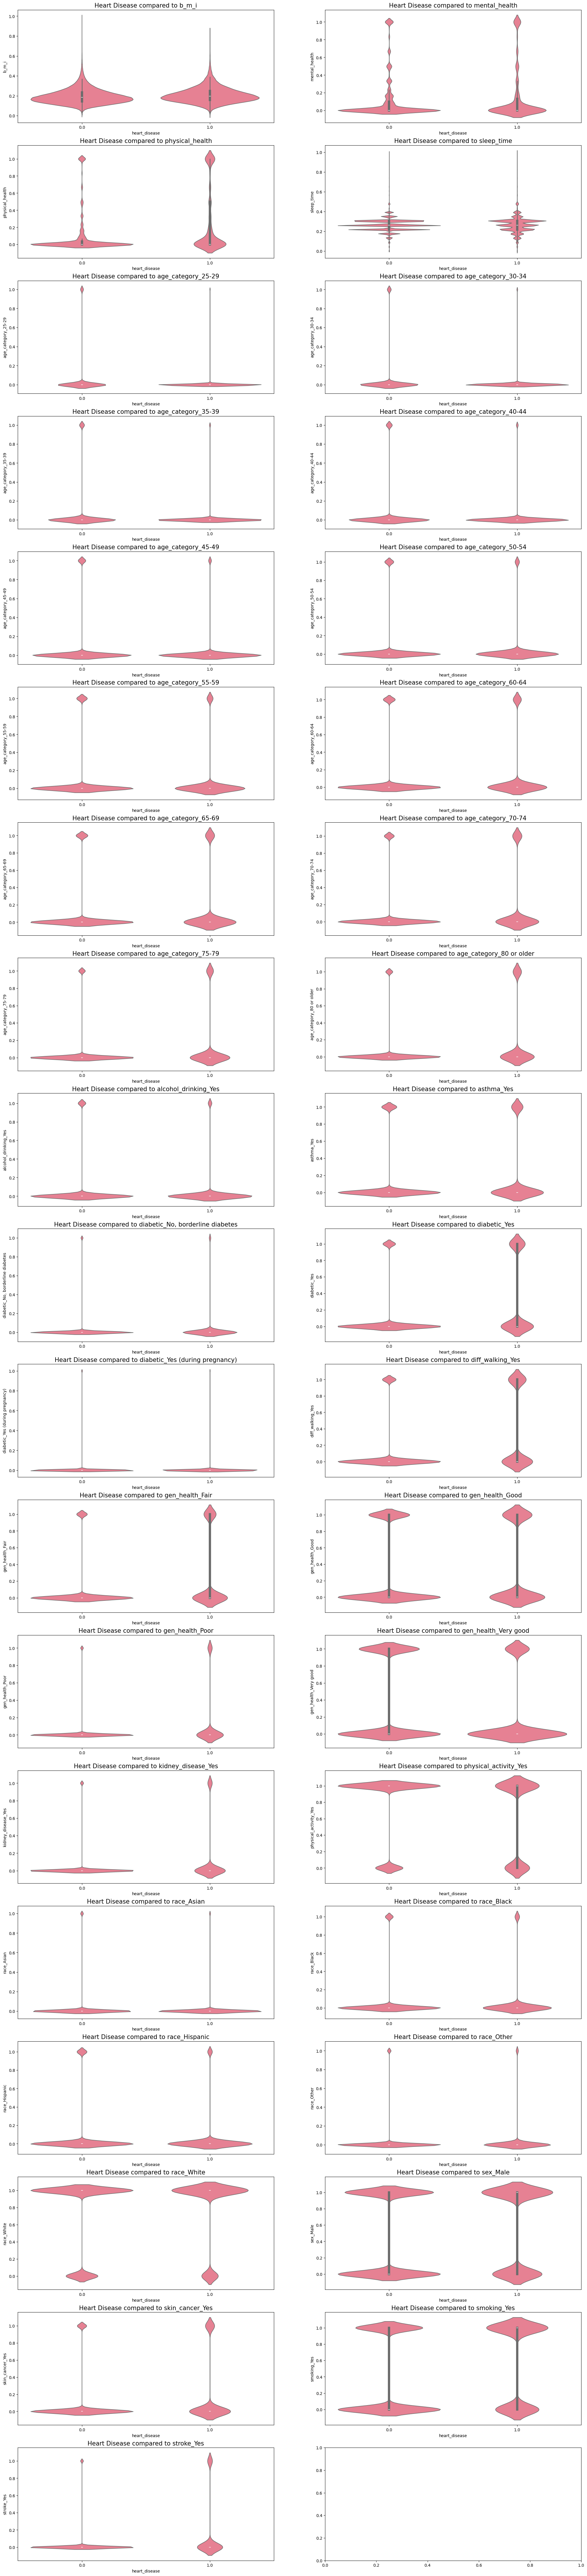

In [22]:
plt.set_loglevel('WARNING')
features = [col for col in transformed_df.columns if col != 'heart_disease' and col != 'timestamp']

num_cols = 2
num_rows = int((len(features) + 1) / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(25, 6 * num_rows))

for i, feature in enumerate(features):
    sns.violinplot(x="heart_disease", y=feature, data=transformed_df, ax=axs[i // num_cols, i % num_cols])
    axs[i // num_cols, i % num_cols].set_title(f"Heart Disease compared to {feature}", fontsize=15)

# Feature Store

In [23]:
heart_fg = fs.get_or_create_feature_group(
    name="heart",
    version=1,
    primary_key=heart_df.columns,
    description="Heart Dataset",
    event_time="timestamp",
)
heart_fg.insert(heart_df)

Uploading Dataframe: 0.00% |          | Rows 0/319795 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: heart_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/196773/jobs/named/heart_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f5d16e81ed0>, None)

# Sythentic Generator

In [ ]:
categorical_cols = new_categorical.tolist() + ['heart_disease']
num_cols = [col for col in transformed_df.columns if col not in categorical_cols]

print(f'Numerical columns: {num_cols}')
print(f'Categorical columns: {categorical_cols}')

Numerical columns: ['b_m_i', 'mental_health', 'physical_health', 'sleep_time']
Categorical columns: ['age_category_25-29', 'age_category_30-34', 'age_category_35-39', 'age_category_40-44', 'age_category_45-49', 'age_category_50-54', 'age_category_55-59', 'age_category_60-64', 'age_category_65-69', 'age_category_70-74', 'age_category_75-79', 'age_category_80 or older', 'alcohol_drinking_Yes', 'asthma_Yes', 'diabetic_No, borderline diabetes', 'diabetic_Yes', 'diabetic_Yes (during pregnancy)', 'diff_walking_Yes', 'gen_health_Fair', 'gen_health_Good', 'gen_health_Poor', 'gen_health_Very good', 'kidney_disease_Yes', 'physical_activity_Yes', 'race_Asian', 'race_Black', 'race_Hispanic', 'race_Other', 'race_White', 'sex_Male', 'skin_cancer_Yes', 'smoking_Yes', 'stroke_Yes', 'heart_disease']


In [ ]:
batch_size = 250
epochs = 20
learning_rate = 5e-6
beta_1 = 0.9
beta_2 = 0.99

ctgan_args = ModelParameters(batch_size=batch_size,
                             lr=learning_rate,
                             betas=(beta_1, beta_2))

train_args = TrainParameters(epochs=epochs)

synth = RegularSynthesizer(modelname='ctgan', model_parameters=ctgan_args)
synth.fit(data=transformed_df, train_arguments=train_args, cat_cols=categorical_cols, num_cols=num_cols)

2023-12-27 09:59:48.459121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 09:59:48.459494: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch: 0 | critic_loss: -0.7055805921554565 | generator_loss: -0.19508159160614014
Epoch: 1 | critic_loss: 0.3029388189315796 | generator_loss: -0.3073885440826416
Epoch: 2 | critic_loss: 0.15348204970359802 | generator_loss: 0.05212998390197754
Epoch: 3 | critic_loss: 0.43040746450424194 | generator_loss: 0.24390554428100586
Epoch: 4 | critic_loss: -0.00024164468050003052 | generator_loss: 0.5955197811126709
Epoch: 5 | critic_loss: 0.23591075837612152 | generator_loss: 0.3184008300304413
Epoch: 6 | critic_loss: 0.2638940215110779 | generator_loss: 0.24068105220794678
Epoch: 7 | critic_loss: 0.06378279626369476 | generator_loss: 0.30546262860298157
Epoch: 8 | critic_loss: 0.2418440729379654 | generator_loss: -0.16732239723205566
Epoch: 9 | critic_loss: -0.043447427451610565 | generator_loss: 0.15602928400039673
Epoch: 10 | critic_loss: -0.08465743064880371 | generator_loss: 0.18745826184749603
Epoch: 11 | critic_loss: 0.35230737924575806 | generator_loss: 0.20967862010002136
Epoch: 12 

# Model Registry

In [ ]:
# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="heart_generator"
os.makedirs(model_dir, exist_ok=True)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
synth.save(f'{model_dir}/heart_generator.pkl')
# Save inverse_pipeline
inverse_pipeline.save(f'{model_dir}/inverse_pipeline.pkl')

# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# Create a schema for the model
output_schema = Schema(transformed_df)
model_schema = ModelSchema(output_schema=output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
heart_generator = mr.python.create_model(
    name="heart_generator", 
    model_schema=model_schema,
    description="Heart Generator Model",
)

heart_generator.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/87998609 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/9905 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/3052 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/196773/models/heart_generator/1


Model(name: 'heart_generator', version: 1)